In [13]:
import pandas as pd
file_path = '104_data_20240501.xlsx'
data = pd.read_excel(file_path)

data.head()

# 提取 '職務內容' 及 '其他條件' 兩列
selected_columns = data[['職務內容', '其他條件']]

# 將提取的內容保存到新的Excel文件
output_file_path = 'textual_analysis.xlsx'
selected_columns.to_excel(output_file_path, index=False)

print(f"已將 '職務內容' 及 '其他條件' 兩列保存到 {output_file_path}")

已將 '職務內容' 及 '其他條件' 兩列保存到 textual_analysis.xlsx


In [14]:
import pandas as pd
file_path = 'textual_analysis.xlsx'
data = pd.read_excel(file_path)

data.head()

,職務內容,其他條件
0,"1.電控規劃與設計 \n2.電控設備安裝與配線\n3.PLC,HMI軟體設計,開發(台達...",NaN
1,(1) 熟悉C/C++程式開發\n(2) 熟悉Windows程式開發者尤佳\n(3) 產品功...,【加分項目】\n1. 擁有良好的代碼習慣，要求結構清晰，命名規範，邏輯性強，代碼冗餘率低。\...
2,《關於重高》\n我們是一間重視技術與服務的公司，在提升客戶的技術力上有著豐富的經驗。我們鼓勵...,You will do really well in this role if you:\n...
3,Responsibilities\n1. Add new features to our d...,1. Interested in developing the novel document...
4,【Job Description】 \n1. Develop Low latency Tr...,・Good C programming and debugging skills.\n・Go...


In [16]:
# 將職務內容 以及 其他條件 欄位的兩千多筆資料 分別成一個字串
job_content_text = data['職務內容'].fillna('').astype(str).str.cat(sep=' ')
# job_content_text

## 職務內容

### 資料清洗

In [17]:
import re
# 清理文本，只保留中文字，去除所有非中文字符
cleaned_text = re.sub(r'[^\u4e00-\u9fff]+', '', job_content_text)

### 移除停用詞

In [18]:
# 讀取停用詞文件
with open('stop_words.txt', 'r', encoding='utf-8') as f:
    stopwords = {line.strip() for line in f}

# 將文本寫入至filtered_sentences.txt中
with open('filtered_sentences.txt', 'w', encoding='utf-8') as f:
    # 將cleaned_text拆分成單詞列表
    words = cleaned_text.split()
    
    # 移除停用詞
    filtered_words = [word for word in words if word not in stopwords]
    
    # 將過濾後的單詞列表重新組合成字元串，並寫入文件中
    filtered_text = ''.join(filtered_words)
    f.write(filtered_text)

### ckiptagger 斷詞

In [19]:
# 自定義字典
from ckiptagger import construct_dictionary

# word_to_weight = {
#     "慕橙": 1,
#     "一個人": 1,
#     "一個": 2, # 權重較重, 代表會斷詞成 '一個' '人', 而非 '一個人'
# }
# 自定義字典
word_to_weight = {
    "提供協助": 2,"系統設計": 4,"系統維護": 3,"解決問題": 2,"溝通能力": 2,"軟體":1,"問題":1,
    "專案維護": 2,"解決問題": 4,"協助提供": 2,"開發經驗": 2,"工作經驗": 2,"開發":1,"軟體開發": 6,
    "專案管理": 2,"問題解決": 2,"需求分析": 2,"前端後端": 2,"資料庫管理": 2,"熟悉系統": 2
}
dictionary2 = construct_dictionary(word_to_weight)
print(dictionary2)

[(2, {'軟體': 1.0, '問題': 1.0, '開發': 1.0}), (4, {'提供協助': 2.0, '系統設計': 4.0, '系統維護': 3.0, '解決問題': 4.0, '溝通能力': 2.0, '專案維護': 2.0, '協助提供': 2.0, '開發經驗': 2.0, '工作經驗': 2.0, '軟體開發': 6.0, '專案管理': 2.0, '問題解決': 2.0, '需求分析': 2.0, '前端後端': 2.0, '熟悉系統': 2.0}), (5, {'資料庫管理': 2.0})]


In [20]:
from ckiptagger import data_utils, construct_dictionary, WS
ws = WS("./data")

AttributeError: `LSTMCell` is not available with Keras 3.

In [ ]:
word_sentence_list = ws([filtered_text], coerce_dictionary=dictionary2, sentence_segmentation=True)

# 輸出斷詞後的結果
print('WS: ', word_sentence_list[0][:100])

### 職缺內容 tf-idf 計算

In [ ]:
import math
import re

# 移除停用詞後再進行斷詞
final_text = [word for sentence in word_sentence_list for word in sentence if len(word) > 1 and not re.match(r"[\d]", word)]

# 計算詞頻
tf = {}
for word in final_text:
    tf[word] = tf.get(word, 0) + 1
total_words = len(final_text)
for word in tf:
    tf[word] /= total_words

# 計算文檔數目
total_docs = len(final_text)  # 請替換 documents 為你的文檔列表，其中每個元素都是一個文檔

# 計算包含每個詞彙的文檔數目
df = {}
for word in set(final_text):
    df[word] = sum(1 for doc in final_text if word in doc)
    # print(f"詞彙 {word} 的 DF 值為: {df[word]}")

# 計算 IDF
idf = {}
for word in df:
    idf[word] = math.log(total_docs / (df[word] + 1))
    # print(f"詞彙 {word} 的 IDF 值為: {idf[word]}")

# 計算 TF-IDF
tfidf = {}
for word in tf:
    tfidf[word] = tf[word] * idf[word]

# 依照 TF-IDF 值排序
sorted_tfidf = sorted(tfidf.items(), key=lambda x: x[1], reverse=True)

# 取得前40項關鍵詞及其對應的 TF、IDF、TF-IDF 值
top_keywords = sorted_tfidf[:45]

# 列印前40項關鍵詞及其對應的 TF、IDF、TF-IDF 值
for word, tfidf_value in top_keywords:
    tf_value = tf[word]
    idf_value = idf[word]
    print(f"詞彙: {word}, TF: {tf_value}, IDF: {idf_value}, TF-IDF: {tfidf_value}")

## 其他條件 

In [11]:
other_requirements_text = data['其他條件'].fillna('').astype(str).str.cat(sep=' ')
# other_requirements_text

In [12]:
import re
# 清理文本，只保留中文字，去除所有非中文字符
cleaned_text_2 = re.sub(r'[^\u4e00-\u9fff]+', '', other_requirements_text)

print(cleaned_text_2[:100])

具有微服務架構經驗機器人相關演算法經驗或生產物流設計規劃經驗者尤佳熟悉多層次傳銷系統者佳孰悉語言並且擁有開發程式的熱忱工作態度良好認真負責科系不拘上過資策會軟體工程師養成班亦歡迎面試曾經學習過一項程式


In [13]:
# 讀取停用詞文件
with open('stop_words.txt', 'r', encoding='utf-8') as f:
    stopwords = {line.strip() for line in f}

# 將文本寫入至filtered_sentences.txt中
with open('filtered_sentences_2.txt', 'w', encoding='utf-8') as f:
    # 將cleaned_text_2拆分成單詞列表
    words = cleaned_text_2.split()
    
    # 移除停用詞
    filtered_words_2 = [word for word in words if word not in stopwords]
    
    # 將過濾後的單詞列表重新組合成字元串，並寫入文件中
    filtered_text_2 = ''.join(filtered_words_2)
    f.write(filtered_text_2)

In [14]:
# 自定義字典
from ckiptagger import construct_dictionary

word_to_weight = {
    "提供協助": 2,"系統設計": 4,"系統維護": 3,"解決問題": 2,"溝通能力": 2,"軟體":1,"問題":1,
    "專案維護": 2,"解決問題": 4,"協助提供": 2,"開發經驗": 2,"工作經驗": 2,"開發":1,"軟體開發": 6,
    "專案管理": 2,"問題解決": 2,"需求分析": 2,"前端後端": 2,"資料庫管理": 2,"熟悉系統": 2
}
dictionary2 = construct_dictionary(word_to_weight)
print(dictionary2)

[(2, {'軟體': 1.0, '問題': 1.0, '開發': 1.0}), (4, {'提供協助': 2.0, '系統設計': 4.0, '系統維護': 3.0, '解決問題': 4.0, '溝通能力': 2.0, '專案維護': 2.0, '協助提供': 2.0, '開發經驗': 2.0, '工作經驗': 2.0, '軟體開發': 6.0, '專案管理': 2.0, '問題解決': 2.0, '需求分析': 2.0, '前端後端': 2.0, '熟悉系統': 2.0}), (5, {'資料庫管理': 2.0})]


In [22]:
from ckiptagger import data_utils, construct_dictionary, WS
ws = WS("./data")

AttributeError: `LSTMCell` is not available with Keras 3.

In [21]:
word_sentence_list_2 = ws([filtered_text_2], coerce_dictionary=dictionary2, sentence_segmentation=True)

# 輸出斷詞後的結果
print('WS: ', word_sentence_list_2[0][:100])

NameError: name 'ws' is not defined

In [12]:
import math
import re

# 移除停用詞後再進行斷詞
final_text_2 = [word for sentence in word_sentence_list_2 for word in sentence if len(word) > 1 and not re.match(r"[\d]", word)]

# 計算詞頻
tf = {}
for word in final_text_2:
    tf[word] = tf.get(word, 0) + 1
total_words = len(final_text_2)
for word in tf:
    tf[word] /= total_words

# 計算文檔數目
total_docs = len(final_text_2)  # 請替換 documents 為你的文檔列表，其中每個元素都是一個文檔

# 計算包含每個詞彙的文檔數目
df = {}
for word in set(final_text_2):
    df[word] = sum(1 for doc in final_text_2 if word in doc)
    # print(f"詞彙 {word} 的 DF 值為: {df[word]}")

# 計算 IDF
idf = {}
for word in df:
    idf[word] = math.log(total_docs / (df[word] + 1))
    # print(f"詞彙 {word} 的 IDF 值為: {idf[word]}")

# 計算 TF-IDF
tfidf = {}
for word in tf:
    tfidf[word] = tf[word] * idf[word]

# 依照 TF-IDF 值排序
sorted_tfidf = sorted(tfidf.items(), key=lambda x: x[1], reverse=True)

# 取得前40項關鍵詞及其對應的 TF、IDF、TF-IDF 值
top_keywords = sorted_tfidf[:45]

# 列印前40項關鍵詞及其對應的 TF、IDF、TF-IDF 值
for word, tfidf_value in top_keywords:
    tf_value = tf[word]
    idf_value = idf[word]
    print(f"詞彙: {word}, TF: {tf_value}, IDF: {idf_value}, TF-IDF: {tfidf_value}")

詞彙: 熟悉, TF: 0.03477782363461274, IDF: 3.3422979245894155, TF-IDF: 0.11623784775570288
詞彙: 經驗, TF: 0.03420002751410098, IDF: 2.9703319266731993, TF-IDF: 0.10158543361823599
詞彙: 相關, TF: 0.020140321914981427, IDF: 3.9036662200320844, TF-IDF: 0.07862109432008489
詞彙: 具備, TF: 0.019975237309120923, IDF: 3.9105108737220498, TF-IDF: 0.07811338270249575
詞彙: 能力, TF: 0.02082817443940019, IDF: 3.7163548592810924, TF-IDF: 0.07740488728781915
詞彙: 開發, TF: 0.01895721557298115, IDF: 3.354827454204348, TF-IDF: 0.06359818725950737
詞彙: 開發經驗, TF: 0.013894620993259046, IDF: 4.27427525263127, TF-IDF: 0.059389434656178054
詞彙: 程式, TF: 0.013536937680561289, IDF: 4.229823490060436, TF-IDF: 0.05725885698472238
詞彙: 團隊, TF: 0.011665978814142247, IDF: 4.4487227529943185, TF-IDF: 0.05189870538642429
詞彙: 使用, TF: 0.010978126289723483, IDF: 4.509347374810754, TF-IDF: 0.04950418496490551
詞彙: 設計, TF: 0.010042646856513963, IDF: 4.53723257830029, TF-IDF: 0.04556582448974015
詞彙: 學習, TF: 0.009850048149676709, IDF: 4.5449745524

## 合併兩個長文本檔案

In [1]:
merged_text = ""
for filename in ['filtered_sentences.txt', 'filtered_sentences_2.txt']:
    with open(filename, 'r', encoding='utf-8') as f:
        merged_text += f.read()

In [2]:
# 寫入新檔案
with open('merged_filtered_sentences.txt', 'w', encoding='utf-8') as f:
    f.write(merged_text)

In [9]:
from ckiptagger import WS

# 讀取停用詞文件
with open('stop_words.txt', 'r', encoding='utf-8') as f:
    stopwords = {line.strip() for line in f}
stopwords = list(stopwords)
stopwords

['誰知',
 '然而',
 '及其',
 '為何',
 '莫若',
 '首先',
 '邊',
 '何況',
 '自',
 '臨',
 '哈哈',
 '別人',
 '哦',
 '另',
 '也',
 '再者',
 '旁人',
 '來',
 '關於',
 '連同',
 '過',
 '其中',
 '這樣',
 '來著',
 '隨',
 '若非',
 '何',
 '至於',
 '用',
 '照',
 '我們',
 '這時',
 '各個',
 '按',
 '若是',
 '某個',
 '另一方面',
 '某',
 '像',
 '要',
 '由此可見',
 '它們',
 '什麼樣',
 '望',
 '了',
 '每當',
 '呸',
 '驗',
 '你',
 '管',
 '任何',
 '甚至',
 '只限',
 '還有',
 '比',
 '有些',
 '那邊',
 '要麼',
 '它',
 '故',
 '啪達',
 '使得',
 '你們',
 '給',
 '由於',
 '其二',
 '寧可',
 '具體地說',
 '冒',
 '他們',
 '要不然',
 '哩',
 '跟',
 '所',
 '果真',
 '一',
 '該',
 '哇',
 '或者',
 '是',
 '幾',
 '她',
 '則',
 '怎',
 '各種',
 '在',
 '任',
 '以至',
 '根據',
 '果然',
 '噓',
 '乎',
 '焉',
 '進而',
 '為著',
 '者',
 '喲',
 '並且',
 '非',
 '同',
 '又',
 '上',
 '就是說',
 '豈但',
 '倘',
 '憑藉',
 '起',
 '若',
 '嘔',
 '到',
 '等',
 '可以',
 '的話',
 '慢說',
 '要是',
 '正如',
 '即',
 '有的',
 '幾時',
 '離',
 '甚麼',
 '乃至',
 '那',
 '漫說',
 '隨著',
 '但是',
 '而',
 '己',
 '兩者',
 '麼',
 '矣',
 '似的',
 '向著',
 '其次',
 '嗡嗡',
 '另外',
 '第',
 '吧',
 '誰',
 '與其',
 '要不',
 '時候',
 '我',
 '其一',
 '人家',
 '啦',
 '靠',
 '可是',
 '咳',
 '盡',
 '人',
 '其他'

In [12]:
# 使用CKIP斷詞
ws = WS("./data")
word_sentence_list = ws([merged_text], sentence_segmentation=True)

word_sentence_list

C:\Users\young\anaconda3\envs\python38\lib\site-packages\ckiptagger\model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)


[['職位',
  '描述',
  '我們',
  '正在',
  '尋找',
  '有',
  '經驗',
  '的',
  '軟體',
  '工程師',
  '加入',
  '開發',
  '團隊',
  '理想',
  '候選人',
  '需',
  '至少',
  '有',
  '年',
  '以上',
  '的',
  '軟體',
  '開發',
  '經驗',
  '並',
  '對於',
  '軟體',
  '開發',
  '週期',
  '有',
  '深刻',
  '的',
  '了解',
  '主要',
  '職責',
  '與',
  '其他',
  '團隊',
  '合作',
  '包含',
  '硬體',
  '和',
  '韌體',
  '研發',
  '團隊',
  '共同',
  '設計',
  '開發',
  '和',
  '維護',
  '高',
  '質量',
  '的',
  '軟體',
  '解決',
  '方案',
  '參與',
  '完整',
  '的',
  '軟體',
  '開發',
  '週期',
  '包括',
  '需求',
  '分析',
  '設計',
  '編碼',
  '測試',
  '部署',
  '和',
  '維護',
  '開發',
  '跨',
  '平台',
  '應用',
  '程式',
  '包含',
  '自動化',
  '程式',
  '及',
  '使用',
  '者',
  '端',
  '應用',
  '程式',
  '控制',
  '開發',
  '進行',
  '代碼',
  '審查',
  '簡化',
  '繁瑣',
  '流程',
  '並',
  '確保',
  '代碼',
  '質量',
  '性能',
  '和',
  '安全性',
  '發現',
  '和',
  '解決',
  '技術',
  '負債',
  '錯誤',
  '和',
  '效能',
  '瓶頸',
  '與',
  '利益',
  '相關',
  '者',
  '合作',
  '理解',
  '需求',
  '並',
  '將',
  '其',
  '轉化為',
  '技術',
  '規範',
  '隨時',
  '了',
  '解',
  '新興',
  '技術',
  '和',
  '

In [12]:
import math
import re

# 移除停用詞後再進行斷詞
final_text_2 = [word for sentence in word_sentence_list for word in sentence if len(word) > 1 and not re.match(r"[\d]", word)]

# 計算詞頻
tf = {}
for word in final_text_2:
    tf[word] = tf.get(word, 0) + 1
total_words = len(final_text_2)
for word in tf:
    tf[word] /= total_words

# 計算文檔數目
total_docs = len(final_text_2)  # 請替換 documents 為你的文檔列表，其中每個元素都是一個文檔

# 計算包含每個詞彙的文檔數目
df = {}
for word in set(final_text_2):
    df[word] = sum(1 for doc in final_text_2 if word in doc)
    # print(f"詞彙 {word} 的 DF 值為: {df[word]}")

# 計算 IDF
idf = {}
for word in df:
    idf[word] = math.log(total_docs / (df[word] + 1))
    # print(f"詞彙 {word} 的 IDF 值為: {idf[word]}")

# 計算 TF-IDF
tfidf = {}
for word in tf:
    tfidf[word] = tf[word] * idf[word]

# 依照 TF-IDF 值排序
sorted_tfidf = sorted(tfidf.items(), key=lambda x: x[1], reverse=True)

# 取得前40項關鍵詞及其對應的 TF、IDF、TF-IDF 值
top_keywords = sorted_tfidf[:35]

# 列印前40項關鍵詞及其對應的 TF、IDF、TF-IDF 值
for word, tfidf_value in top_keywords:
    tf_value = tf[word]
    idf_value = idf[word]
    print(f"詞彙: {word}, TF: {tf_value}, IDF: {idf_value}, TF-IDF: {tfidf_value}")

NameError: name 'word_sentence_list' is not defined

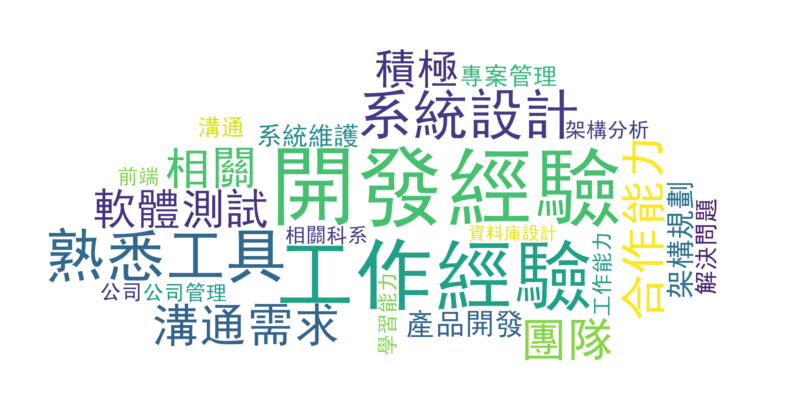

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud

font_path = '/Users/young/miniconda3/envs/generic_algorithm/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf'

mask_image_path = 'word-cloud-example.png'
mask_image = np.array(Image.open(mask_image_path))


# 已经计算好的词汇及其对应的 TF-IDF 值
words_tfidf = {
    "開發經驗": 0.11354443667988297,
    "工作經驗": 0.09033356386666165,
    "熟悉工具": 0.07305893865817645,
    "系統設計": 0.06226168059275725,
    "溝通需求": 0.05449450756210652,
    "合作能力": 0.05385368191158085,
    "軟體測試": 0.05291233298904071,
    "相關": 0.052678620878028604,
    "團隊": 0.05262938312226217,
    "專案管理": 0.05158882222129625,
    "軟體測試": 0.04798240397618557,
    "積極": 0.04456781187814063,
    "產品開發": 0.0371108211931854,
    "架構規劃": 0.0371108211931854,
    "系統維護": 0.03532878846988254,
    "專案管理": 0.033968167083538926,
    "解決問題": 0.032774108856786714,
    "溝通": 0.03057205589631608,
    "工作能力": 0.02583156505508566,
    "公司": 0.025779969518149422,
    "公司管理": 0.02520982125669955,
    "架構分析": 0.024860598363370234,
    "學習能力": 0.024860598363370234,
    "前端": 0.024860598363370234,
    "相關科系": 0.024860598363370234,
    "資料庫設計": 0.024860598363370234,
}

wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    font_path=font_path, 
    mask=mask_image
)
wordcloud.generate_from_frequencies(words_tfidf)

# 显示文字云
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()